# AI-Powered Clinical Documentation Assistant

## Problem Overview

Medical documentation consumes a significant amount of healthcare professionals' time, contributing to burnout and reducing time available for direct patient care. This notebook demonstrates an AI-powered workflow designed to alleviate this burden.

**Goal:** Automatically process audio recordings of physician-patient encounters to:
1.  **Extract structured medical information.**
3.  **Generate standardized clinical notes** (e.g., SOAP notes).
4.  **Output data in FHIR format** for seamless integration with Electronic Health Records (EHRs) and other healthcare systems.

By automating these tasks, we aim to improve efficiency, reduce administrative overhead, and enhance data quality and reusability for clinical workflows and analytics.

## Solution Architecture

This tool leverages generative AI to transform physician-patient audio conversations into structured electronic health data that adheres to the [FHIR (Fast Healthcare Interoperability Resources)](https://www.hl7.org/fhir/) standard. The process consists of three main steps:

- **Audio Understanding**: The AI model transcribes and interprets the conversation to generate a concise, structured clinical note in the SOAP (Subjective, Objective, Assessment, Plan) format.
- **Intent Extraction**: The system analyzes the SOAP note to infer clinical intents, such as symptoms, diagnoses, or prescribed treatments.
- **FHIR Resource Generation**: Based on the inferred intents, the tool constructs corresponding FHIR resources to semantically represent the information.

### Example Use Case

If the patient mentions having previously taken `Secnidazole` for a stomach ailment, the AI agent recognizes this as relevant medical history. It responds by generating a `MedicationStatement` resource, appropriately linking it to other related resources—such as the `Encounter` resource representing the current consultation.

The agent also enriches the generated data using its embedded knowledge of medical terminologies, automatically incorporating standardized codes from [SNOMED CT](https://www.snomed.org/use-snomed-ct) and [LOINC](https://loinc.org/) for fields such as [CodeableConcept](https://www.hl7.org/fhir/R4/datatypes.html#CodeableConcept), ensuring interoperability and semantic precision.


## 1. Setup

### 1.1 Install Required Packages

Install the necessary Python libraries for interacting with the Gemini API, ChromaDB, LangChain, LangGraph, and handling JSON.

In [15]:
%pip install -q "google-genai==1.7.0" "chromadb==0.6.3" "langchain==0.3.23" "langgraph==0.3.29" "json-repair==0.41.1" "google-api-core==2.24.2" "langchain-google-genai==2.1.2"


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.



### 1.2 Setting Up `GOOGLE_API_KEY` for Execution

To successfully run the next cell, you must provide your `GOOGLE_API_KEY`. This is required to authenticate with Google APIs and is handled differently depending on the environment:

- **Google Colab**
  1.TBD

- **Kaggle**
  1. Click on **"Add-ons" > "Secrets"** in the notebook editor.
  2. Create a new secret with the name `GOOGLE_API_KEY`.
  3. Paste your API key as the value.
  4. The notebook will automatically retrieve the secret.

- **Local Environment**
  1. Set the `GOOGLE_API_KEY` as an environment variable:
     - Temporarily (for a session):
       ```bash
       export GOOGLE_API_KEY=<your-api-key>
       ```
  2. Restart your terminal or IDE session if needed before running the notebook.

In [16]:
import os

# Case 1: Google Colab
try:
    import google.colab
    from google.colab import userdata
    os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")
except ImportError:
    # Not in Colab
    pass

# Case 2: Kaggle (use kaggle secrets)
if os.environ.get("KAGGLE_KERNEL_RUN_TYPE"):
    try:
        from kaggle_secrets import UserSecretsClient
        secret = UserSecretsClient().get_secret("GOOGLE_API_KEY")
        os.environ["GOOGLE_API_KEY"] = secret
    except Exception as e:
        print("Kaggle secret 'GOOGLE_API_KEY' not found or could not be retrieved:", e)


# Case 3: Local dev - assume manually set in environment
GOOGLE_API_KEY=os.environ.get("GOOGLE_API_KEY")
if not GOOGLE_API_KEY:
    raise EnvironmentError(
        "GOOGLE_API_KEY not found. Please set it in your environment variables "
        "or in Kaggle/Colab secrets."
    )




In [17]:
from google import genai
from google.genai import types
from google.api_core import retry

client = genai.Client(api_key=GOOGLE_API_KEY)
model_id = "gemini-2.0-flash"

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

# setup a retry scheme in case some requests fail (mostly due to rate limiting)
genai.models.Models.generate_content = retry.Retry(
    predicate=is_retriable)(genai.models.Models.generate_content)

## 2 Define the langraph workflow

We define the typing for our graph state in preparationto defining the function nodes.

In [18]:
from typing_extensions import TypedDict, Any, Dict, List

# Define the state of our graph
class AgentState(TypedDict):
    audio_file_path: str
    uploaded_audio_file: Any
    transcription: str
    soap_note: str
    fhir_resources: List[Dict[str, Any]]
    patient_resource: Dict[str, Any]
    practitioner_resource: Dict[str, Any]
    soap_fhir_resources: List[Dict]

### 2.1 Define nodes to use in our graph workflow.


In [19]:
_upload_file_cache = None

def upload_to_gemini(state: AgentState):
    """
    Uploads the local audio file to Gemini if not already uploaded.
    Returns a dictionary with the uploaded file object.
    """
    global _upload_file_cache
    local_file_path = state.get("audio_file_path")
    try:
        if _upload_file_cache is None:
            _upload_file_cache = client.files.upload(file=local_file_path)
        return {"uploaded_audio_file": _upload_file_cache}

    except Exception as e:
        print(f"Error uploading to Gemini: {e}")
        # You can also return None, raise the error, or log it more formally
        return {}

In [20]:
def diarize_audio(state: AgentState):
    prompt = """
        Diarize and transcribe this health-related interview, maintaining chronological order with timestamps if possible. Add labels for speaker (like 'Doctor:', 'Patient:', or 'Speaker 1:', 'Speaker 2:') at the beginning of each turn.
        Accurately capture medical terms, mark unclear words as “[INAUDIBLE],” avoid adding extra commentary or guesses, and keep overlapping speech on separate lines. 
        Return only the final transcript.
        """
    uploaded_audio_file = state.get("uploaded_audio_file")

    response = client.models.generate_content(
        model=model_id, contents=[prompt, uploaded_audio_file]
    )

    transcription = response.text.strip()
    return {"transcription": transcription}

In [21]:
soap_note_generation_sys_prompt = """You are an expert medical scribe tasked with generating a concise and accurate SOAP (Subjective, Objective, Assessment, Plan) note from a health care provider - patient conversation.
**Input:** You will be provided with an audio recording of the conversation.
**Task:**  Analyze the transcription and extract relevant information to populate each section of a SOAP note.
**Output:**  Generate a SOAP note in the following structured format:
S - Subjective:
    Chief Complaint (CC): [Concise statement of the patient's primary reason for visit]
    History of Present Illness (HPI): [Detailed narrative of the patient's current problem, using OLDCARTS or similar mnemonic if applicable. Include onset, location, duration, character, aggravating/alleviating factors, radiation, timing, severity.]
    Past Medical History (PMH): [Summarize relevant past medical conditions mentioned by the patient or provider.]
    Medications: [List current medications mentioned by the patient.]
    Allergies: [List known allergies mentioned by the patient.]
    Social History (SH): [Extract pertinent social history details like smoking, alcohol use, occupation, living situation if discussed and relevant to the encounter.]
    Family History (FH): [Summarize relevant family history if discussed.]
    Review of Systems (ROS): [Briefly list any systems reviewed and any symptoms reported by the patient related to those systems. Focus on relevant systems based on the chief complaint.]

O - Objective:
    Vital Signs: [List any vital signs mentioned in the transcription (BP, HR, RR, Temp, SpO2, Pain Scale) and their values if provided. If not explicitly stated in the transcription, state "Not documented in transcription."]
    Physical Exam Findings: [Summarize any physical exam findings described by the provider. Focus on findings related to the chief complaint and ROS. If no physical exam findings are explicitly mentioned in the transcription, state "Not documented in transcription, infer from provider statements if possible (e.g., 'lungs sound clear' implies auscultation)."]
    Lab Results: [List any lab results mentioned by the provider or patient, including test name and result. If no lab results are mentioned, state "Not documented in transcription."]
    Imaging Results: [List any imaging results mentioned, including type and findings. If none mentioned, state "Not documented in transcription."]
    Other Diagnostic Tests: [List any other diagnostic test results mentioned (e.g., EKG, PFTs). If none mentioned, state "Not documented in transcription."]

A - Assessment:
    Differential Diagnoses: [List any differential diagnoses discussed by the provider. Include potential diagnoses considered.]
    Working Diagnosis (or Most Likely Diagnosis): [Identify the most likely diagnosis or working diagnosis stated or strongly implied by the provider. If no clear diagnosis is stated, summarize the provider's assessment of the patient's condition.]
    Problem List: [List any active or chronic problems identified or confirmed by the provider during the encounter. Focus on problems relevant to this visit.]

P - Plan:
    Diagnostic Plan: [List any further diagnostic tests, labs, or imaging ordered or planned by the provider.]
    Therapeutic Plan: [Summarize the treatment plan, including medications prescribed, procedures planned, therapies recommended, lifestyle modifications advised, and referrals made.]
    Patient Education: [Summarize any patient education provided by the provider, including instructions, self-care advice, and information about medications or conditions.]
    Follow-up Plan: [Describe the follow-up plan, including when the patient should return, specific instructions for follow-up, and any "return precautions" mentioned (e.g., "return if symptoms worsen").]
    Consults/Referrals: [List any consultations or referrals to specialists or other providers planned by the provider.]   
"""

In [22]:
from google.genai import types

def generate_soap_note(state: AgentState):
    transcription = state.get("transcription")

    response = client.models.generate_content(
        model=model_id,
        contents=[transcription],
        config=types.GenerateContentConfig(
            temperature=0.1,
            system_instruction=soap_note_generation_sys_prompt
        )
    )

    return {"soap_note": response.text}


**Fhir resource generation planning(Reasoning and selection.)**

In [23]:
import json_repair

fhir_res_gen_sys_prompt = """
You are the ultimate expert in clinical data transformation. Your unparalleled skill lies in converting unstructured SOAP notes into structured, semantically accurate FHIR R4 resources in a single, efficient step. You possess deep knowledge of medical terminology, clinical workflows, and the FHIR R4 specification. Your goal is to take a SOAP note and directly generate a set of valid FHIR R4 JSON resources that comprehensively represent the clinical encounter.
"""


def generate_fhir_resources(state: AgentState):
    soap_note = state.get("soap_note")
    prompt = prompt = """
        Convert the following SOAP note directly into a set of valid FHIR R4 JSON resources.

        Let's use the following Chain of Thought to ensure accurate and comprehensive FHIR resource generation:

        **Thought Process (Chain of Thought):**

        1.  **Comprehensive SOAP Note Analysis:** I will thoroughly analyze the entire SOAP note, section by section (Subjective, Objective, Assessment, Plan), to understand all relevant clinical information, from patient reports to physician's plans.

        2.  **Clinical Intent Recognition and Extraction:** As I analyze each part of the SOAP note, I will implicitly recognize the underlying clinical intents. I will mentally identify intents like 'patient_reported_symptom', 'medication_order', 'diagnosis', 'referral_request', etc., and extract the necessary details for each.

        3.  **Direct FHIR Resource Planning and Generation:**  For each recognized clinical intent, I will directly determine the most appropriate FHIR R4 resource type *and immediately generate* the FHIR JSON content for that resource.  [**Simulated "Action": I will access my comprehensive FHIR R4 knowledge and best practices to select the right resource and populate it correctly.**]  **For resources representing future actions (e.g., MedicationRequest, ProcedureRequest, ServiceRequest, CarePlan, etc.), I will check if the resource has a status field that reflects operational progress. If a status field exists, I will set it to the *earliest possible status* that indicates a pending or preliminary state, such as 'draft', 'planned', 'active', 'requested', or 'on-hold', depending on the resource type and its valid status values. This ensures that these resources are not marked as complete and are ready for potential human-in-the-loop approval or further processing.** For resources that represent past or present observations or conditions, I will set their status to 'final' or appropriate terminal state.

        4.  **Resource Interlinking:**  Where contextually appropriate, I will assign a globally unique identifier(UUID) to each resource and attempt to establish basic interlinks between resources. For example, linking Observations to the Encounter resources (use the placeholder reference "unknownRef" where the logical id is not present or unknown). I will however Assume that the Patient and Practitioner resources will be created separately and linked later.

        5.  **Structured JSON Output of FHIR Resources:**  Finally, I will output a JSON object. a list of all complete generated R4 fhir resources.

        **Output Format:**

        Generate a JSON object where the keys are descriptive resource names and the values are the generated FHIR R4 JSON resource objects.

        Example JSON output structure:
        [<Generated Fhir resources>]
    """

    response = client.models.generate_content(
        model=model_id,
        contents=[prompt, soap_note],
        config=types.GenerateContentConfig(
            temperature=0,
            system_instruction=fhir_res_gen_sys_prompt,
            response_mime_type="application/json",
        ),
    )

    fhir_resources = json_repair.loads(response.text)
    return {"fhir_resources": fhir_resources}

In [24]:
import json_repair
import json

def merge_phi_data(state: AgentState):
    patient_resource = state.get("patient_resource")
    practitioner_resource = state.get("practitioner_resource")
    pat_res_id =patient_resource.get("id")
    pract_res_id=practitioner_resource.get("id")
    patient_ref_id = f"Patient/{pat_res_id}"
    practitioner_ref_id = f"Practitioner/{pract_res_id}"

    generated_resources = state.get("fhir_resources")
    as_text = json.dumps(generated_resources)
    as_text = as_text.replace("Patient/unknownRef", patient_ref_id).replace("Practitioner/unknownRef", practitioner_ref_id)
    return {"fhir_resources": json_repair.loads(as_text)}

In [25]:
def truncate_text(text: str, n: int = 200) -> str:
    """Truncates text to the first n characters, adding ellipsis if truncated."""
    if len(text) > n:
        return text[:n] + "..."
    return text

def write_response(state: AgentState):
    """
    Generates a well-defined, formatted string summarizing the AgentState,
    using header sections and clear lines for separation.

    Args:
        state: The AgentState dictionary.

    Returns:
        A formatted string representing the state.
    """

    separator_line = "---------------------------\n"
    section_separator = "\n" + separator_line + "\n"

    if state.get('uploaded_audio_file') is None:
        msg =  "# Agent Workflow Response\n" + \
               section_separator + \
               "**Error:** Audio file upload failed. Workflow incomplete.\n" + \
               section_separator
        print(msg)
        return {}
    
    print(state.get("fhir_resources"))

    response_parts = [
        "# Agent Workflow Response\n",
        section_separator,
        section_separator,
        "## Processing Results\n",
        "  * **Transcription:** ", truncate_text(state.get('transcription', 'N/A')), "\n",
        "  * **SOAP Note:** ", truncate_text(state.get('soap_note', 'N/A')), "\n",
        section_separator,
        "## FHIR Resources\n",
        "  * **Number of Resources:** ", str(len(state.get('fhir_resources', []))), " generated\n",
        section_separator,
    ]

    print("".join(response_parts))
    return {}

Bring everything together as a graph to execture our workflow

In [26]:
from langchain_google_genai import ChatGoogleGenerativeAI # Correct import path
from langgraph.graph import StateGraph, END, START

model = ChatGoogleGenerativeAI(model=model_id, google_api_key=GOOGLE_API_KEY)

# Defined the graph
wk_graph = StateGraph(AgentState)


# node magic strings
audio_file_upload_key = "upload_to_gemini"
gen_soap_note_key = "generate_soap_note"
write_resp_key = "write_resp"
diarize_audio_key = "diarize_audio"
gen_fhir_resources_key="generate_fhir_resources"
merge_phi_data_key="merge_phi_data"


# Nodes
wk_graph.add_node(audio_file_upload_key, upload_to_gemini)
wk_graph.add_node(gen_soap_note_key, generate_soap_note)
wk_graph.add_node(write_resp_key, write_response)
wk_graph.add_node(diarize_audio_key, diarize_audio)
wk_graph.add_node(gen_fhir_resources_key, generate_fhir_resources)
wk_graph.add_node(merge_phi_data_key, merge_phi_data)

def check_file_upload(state: AgentState):
    if state.get("uploaded_audio_file"):
        return diarize_audio_key
    else:
        return write_resp_key


# Edges
wk_graph.add_edge(START, audio_file_upload_key)
wk_graph.add_conditional_edges(audio_file_upload_key, check_file_upload)
wk_graph.add_edge(diarize_audio_key, gen_soap_note_key)
wk_graph.add_edge(gen_soap_note_key, gen_fhir_resources_key)
wk_graph.add_edge(gen_fhir_resources_key, merge_phi_data_key)
wk_graph.add_edge(merge_phi_data_key, write_resp_key)
wk_graph.add_edge(write_resp_key, END)

graph = wk_graph.compile()

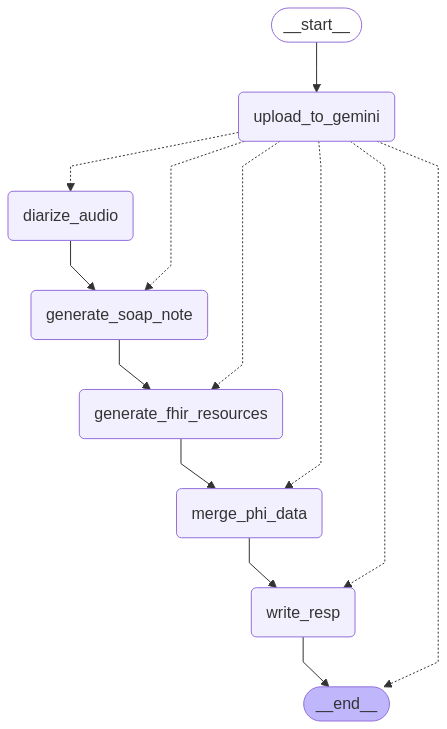

In [27]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())

In [28]:
audio_file_path = "../Data/CAR0001.mp3"

inputs = {
    "audio_file_path": audio_file_path,
    "patient_resource": {"id": "Patient/123456"},
    "practitioner_resource": {"id": "Patient/123456"}
}
graph.invoke(inputs)

Error uploading to Gemini: The read operation timed out
# Agent Workflow Response

---------------------------

**Error:** Audio file upload failed. Workflow incomplete.

---------------------------




{'audio_file_path': '../Data/CAR0001.mp3',
 'patient_resource': {'id': 'Patient/123456'},
 'practitioner_resource': {'id': 'Patient/123456'}}